

<font size = "5"> **pyTEMlib : [EELS_tools](../4_EELS_Tools.ipynb)** </font>

<hr style="height:1px;border-top:4px solid #FF8200" />



# Analysing Low-Loss Spectra with Drude Theory
[<img src=https://www.coeuscreativegroup.com/wp-content/uploads/2020/04/download-button.png, width=125>](https://raw.githubusercontent.com/pycroscopy/pyTEMlib/main/notebooks/EELS/Analyse_Low_Loss.ipynb) 

[![OpenInColab](https://colab.research.google.com/assets/colab-badge.svg)](
    https://colab.research.google.com/github/pycroscopy/pyTEMlib/blob/main/notebooks/EELS/Analyse_Low_Loss.ipynb)
    
part of 

<font size = "5"> **[pyTEMlib](https://pycroscopy.github.io/pyTEMlib/about.html)**</font>

a [pycroscopy](https://pycroscopy.github.io/pycroscopy/about.html) ecosystem package
Notebook by 

Gerd Duscher

Microscopy Facilities
Materials Science & Engineering<br>
Institute of Advanced Materials & Manufacturing<br>
The University of Tennessee, Knoxville


Analyse EELS spectra and spectrum images.

## Content
The main feature in a low-loss EELS spectrum is the ``volume plasmon`` peak.

This ``volume plasmon`` and all other features in the ``low-loss`` region of an EELS spectrum are described by Dielectric Theory of Electrodynamics.

The simplest theory to interprete this energy range is the Drude theory. 

Another easy to observe component is the multiple scattering of this plasmon peak, which we can correct for or use for thickness determination.

>See [Notebook: Analysing Low-Loss Spectra with Drude Theory](https://raw.githubusercontent.com/gduscher/MSE672-Introduction-to-TEM/main/Spectroscopy/CH4_03-Drude.ipynb) of the MSE672-Introduction-to-TEM Lecture in my Github account.


## Load important packages

### Check Installed Packages


In [2]:
import sys

from pkg_resources import get_distribution, DistributionNotFound

def test_package(package_name):
    """Test if package exists and returns version or -1"""
    try:
        version = (get_distribution(package_name).version)
    except (DistributionNotFound, ImportError) as err:
        version = '-1'
    return version


# pyTEMlib setup ------------------
if test_package('pyTEMlib') < '0.2023.6.6':
    print('installing pyTEMlib')
    !{sys.executable} -m pip install --upgrade sidpy
    !{sys.executable} -m pip install --upgrade git+https://github.com/pycroscopy/SciFiReaders.git@main -q
    !{sys.executable} -m pip install --upgrade git+https://github.com/pycroscopy/pyTEMlib.git@main -q --upgrade
    
# ------------------------------
print('done')

done


### Import all relevant libraries

Please note that the EELS_tools package from pyTEMlib is essential.

In [2]:
%matplotlib widget
import matplotlib.pylab as plt
import numpy as np

import sys
sys.path.insert(0, '../../')
#sys.path.insert(0, '../../../sidpy')
import sidpy
%load_ext autoreload
%autoreload 2

# additional package 
import ipywidgets as ipyw
from scipy.optimize import leastsq  ## fitting routine of scipy

if 'google.colab' in sys.modules:
    from google.colab import output
    output.enable_custom_widget_manager()
    from google.colab import drive

# Import libraries from the book
import pyTEMlib
import pyTEMlib.file_tools as ft          # File input/ output library
from pyTEMlib import eels_tools  
from pyTEMlib import interactive_eels 
import pyTEMlib.kinematic_scattering as ks         # Kinematic sCattering Library
                             # Atomic form factors from Kirklands book

# For archiving reasons it is a good idea to print the version numbers out at this point
print('pyTEM version: ',pyTEMlib.__version__)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
pyTEM version:  0.2023.9.19.dev1


## Load and plot a spectrum

In [7]:
if 'google.colab' in sys.modules:
    drive.mount("/content/drive")
    
filename = '../../example_data/AL-DFoffset0.00.dm3'

fileWidget = ft.FileWidget()

[sidpy.Dataset of type SPECTRUM with:
 dask.array<array, shape=(2048,), dtype=float32, chunksize=(2048,), chunktype=numpy.ndarray>
 data contains: intensity (counts)
 and Dimensions: 
energy_loss:  energy-loss (eV) of size (2048,)
 with metadata: ['experiment']]
Please use new SciFiReaders Package for full functionality


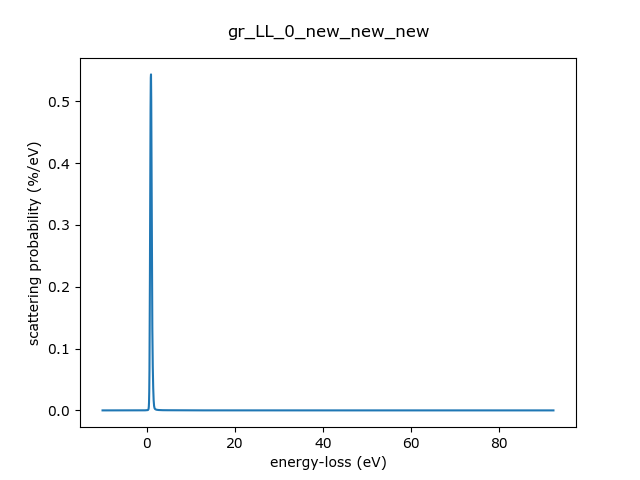

In [4]:
eels_dataset = fileWidget.selected_dataset

if 'SPECTR' not in eels_dataset.data_type.name:
    print('We need an EELS spectrum or spectrum image for this notebook')
if 'SPECTRAL_IMAGE'  in eels_dataset.data_type.name:
    sum_spectrum = np.average(eels_dataset.sum(axis=2))
else:
    sum_spectrum = eels_dataset.sum()
eels_dataset.metadata['low_loss'] = {}

dispersion = eels_dataset.energy_loss[1] - eels_dataset.energy_loss[0]
eels_dataset = eels_dataset / sum_spectrum * 100 * dispersion
eels_dataset.units = '%/eV'
eels_dataset.quantity = 'scattering probability'
view = eels_dataset.plot()

In [6]:
instance(eels_dataset)

NameError: name 'instance' is not defined

Here we do the follwing tasks:
### Fix energy scale and determine resolution function
> please see [Fitting the Zero-Loss Peak](./CH4_02-Fit_Zero_Loss.ipynb) for details

### Determine Relative Thickness 
The probabaility of an low-loss function in a solid angle is then:
$$\frac{\partial^2 P}{(\partial E \partial \Omega) }= t*  \frac{e}{\pi^2 a_0 m_0 v^2} {\rm Im} \left[ \frac{-1}{\varepsilon(q,E)} \right]
         \left( \frac{1}{\theta^2+\theta_E^2}\right)$$
         
>See [Notebook: Analysing Low-Loss Spectra with Drude Theory](https://raw.githubusercontent.com/gduscher/MSE672-Introduction-to-TEM/main/Spectroscopy/CH4_03-Drude.ipynb) of the MSE672-Introduction-to-TEM Lecture in my Github account.




In [11]:
resolution_functions = eels_tools.get_resolution_functions(eels_dataset)
                                                           
resolution_functions
eels_dataset.metadata


{'experiment': {'single_exposure_time': 0.001,
  'exposure_time': 100.0,
  'number_of_frames': 100000,
  'collection_angle': 50.0,
  'convergence_angle': 5.42,
  'acceleration_voltage': 60000.0},
 'filename': 'c:\\Users\\gduscher\\Documents\\2023-Experiments\\09222023eels\\gr_LL_0.dm4',
 'low_loss': {}}

Text(0.5, 1.0, ' thickness - mean: 0.26, std 0.340')

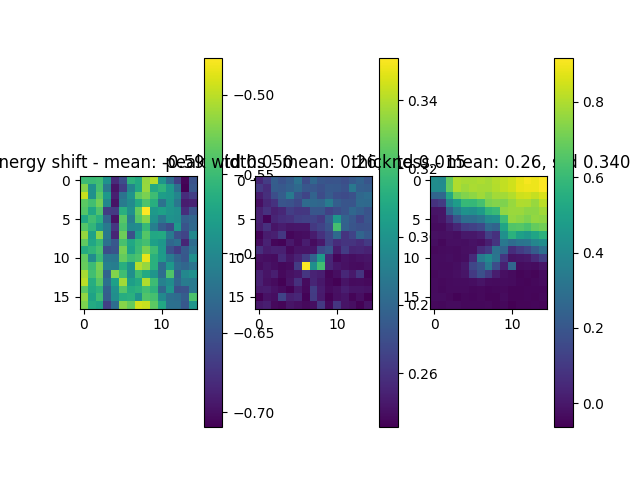

In [5]:
energy_shift = resolution_functions.metadata['low_loss']['shifts']
fwhm = resolution_functions.metadata['low_loss']['widths']

t_mfp = np.log(eels_dataset.sum(axis=2)/resolution_functions.sum(axis=2))

plt.figure()
ax1 = plt.subplot(131)
plt.imshow(energy_shift)
plt.colorbar()
plt.title(f' energy shift - mean: {np.mean(energy_shift):.2f}, std {np.std(energy_shift):.3f}')
ax2 = plt.subplot(132)
plt.imshow(fwhm)
plt.colorbar()
plt.title(f' peak widths - mean: {np.mean(fwhm):.2f}, std {np.std(fwhm):.3f}')
ax3 = plt.subplot(133)
plt.imshow(t_mfp)
plt.colorbar()
plt.title(f' thickness - mean: {np.mean(np.array(t_mfp)):.2f}, std {np.std(np.array(t_mfp)):.3f}')

## Shift energy scale

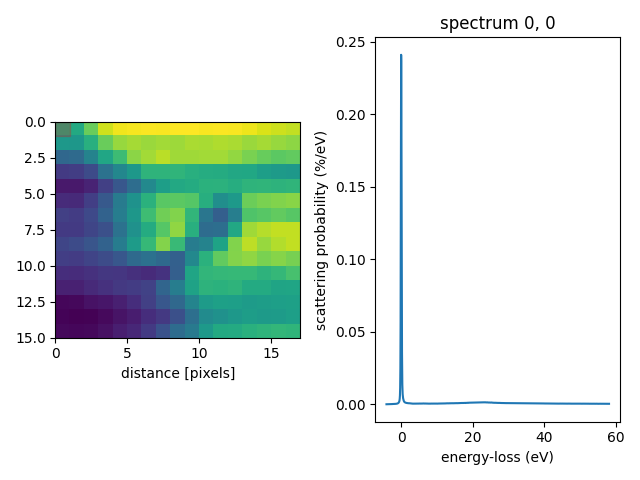

In [6]:
eels_dataset.metadata['low_loss'].update(resolution_functions.metadata['low_loss'])
shifted_dataset = eels_tools.shift_on_same_scale(eels_dataset)
view = shifted_dataset.plot()

c:\Users\gduscher\AppData\Local\anaconda3\envs\pyTEMlib\Lib\site-packages\scipy\optimize\_minpack_py.py:492: RuntimeWarning: Number of calls to function has reached maxfev = 2000.
  warnings.warn(errors[info][0], RuntimeWarning)


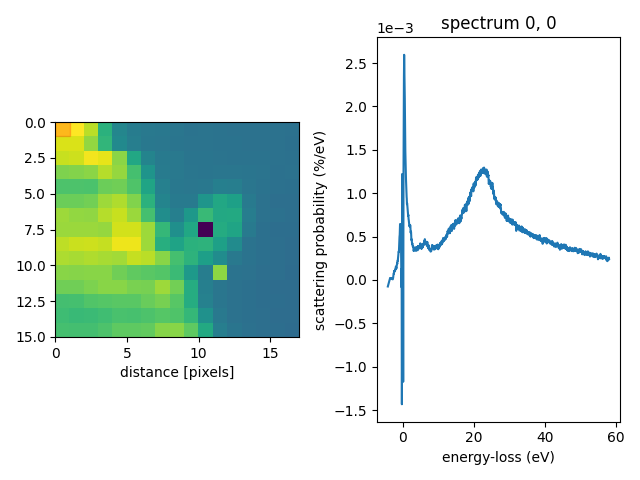

In [7]:
shifted_resolution_functions = eels_tools.get_resolution_functions(shifted_dataset, zero_loss_fit_width=.9)
dif = shifted_dataset - shifted_resolution_functions
view = dif.plot()

In [8]:
datasets = fileWidget.datasets
#datasets['energy_corrected'] = shifted_dataset
#datasets['energy_corrected_resolution_function'] = shifted_resolution_functions

infoWidget= interactive_eels.InfoWidget(datasets)

c:\Users\gduscher\AppData\Local\anaconda3\envs\pyTEMlib\Lib\site-packages\jupyter_client\session.py:719: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


ValueError: array of sample points is empty

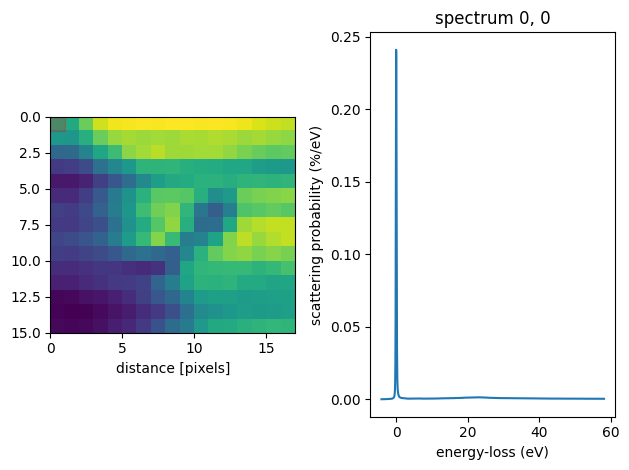

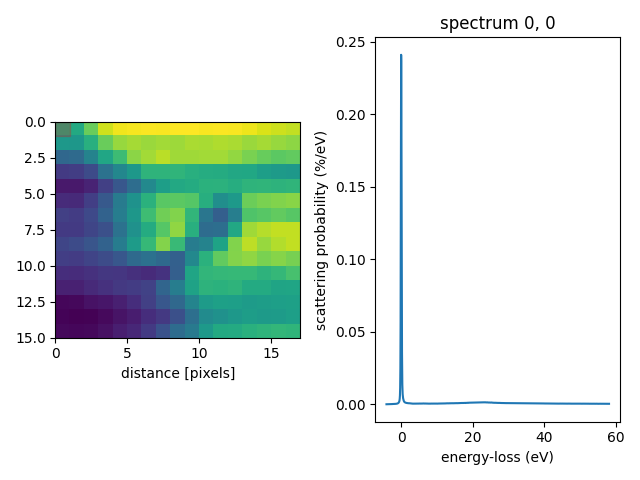

In [15]:
v = shifted_dataset.plot()


In [40]:
FWHM, energy_shift = eels_tools.fix_energy_scale(eels_dataset)

print(f'Zero Loss with energy resolution of {FWHM:.2f} eV at position {energy_shift:.3f} eV')
eels_dataset.energy_loss -= energy_shift

zero_loss, _ = eels_tools.resolution_function(eels_dataset.energy_loss, eels_dataset, .4)
print(zero_loss)
plt.figure()
plt.plot(eels_dataset.energy_loss, eels_dataset, label='spectrum')
plt.plot(eels_dataset.energy_loss, zero_loss, label = 'zero-loss')
plt.plot(eels_dataset.energy_loss, np.array(eels_dataset)-zero_loss , label = 'difference')

plt.title ('Lorentzian Product Fit of Zero-Loss Peak')
#plt.xlim(-5,30)
plt.legend();
Izl = zero_loss.sum()
Itotal = np.array(eels_dataset).sum()
tmfp = np.log(Itotal/Izl)
print(f'Sum of Zero-Loss: {Izl:.3f} %')
print(f'Sum of Spectrum: {Itotal:.3f} %')
print (f'thickness [IMFP]: {tmfp:.5f}')

ValueError: object of too small depth for desired array

## Fitting a Drude Function to Plasmon

The position and the width are important materials parameters and we can derive them by fitting the Drude function to the volume plasmon region.
### Drude Function

Most of the inelastically scattered electron arise from interaction with outer shell electrons. These interactions, therefore, have a high intensity and are easy to obtain. 

The energy-loss function $F_{el}$ on the other hand is determined by the dielectric function $\varepsilon$ through:

$$
F_{el} = \Im \left[\frac{-1}{\varepsilon(\omega)} \right]
$$

The dielectric function in the Drude theory is given by two input parameters the position of the plasmon energy $E_p$
and the width of the plasmon $\Gamma$

$$ ε(ω) = ε1 + iε2 = 1 + χ = 1 − \frac{\omega_p^2}{\omega^2+\Gamma^2} + \frac{i\Gamma \omega_p^2}{\omega(\omega^2+\Gamma^2)}$$
Here $\omega$ is the angular frequency (rad/s) of forced oscillation and $\omega_p$ is the natural or resonance frequency for plasma oscillation, given by
$$ ω_p = \sqrt{\frac{ne^2}{(ε_0m_0)}} $$
A transmitted electron represents a sudden impulse of applied electric field, containing
all angular frequencies (Fourier components). Setting up a plasma oscillation of the loosely bound outer-shell electrons in a solid is equivalent to creating a pseudoparticle of energy $E_p = \hbar \omega_p$, known as a plasmon (Pines, 1963).

Drude Theory with Plamson Energy: 15.048551 eV and plasmon Width 0.72 eV
Max of Plasmon at 15.04 eV
Amplitude of  0.00 was deteremined by fit 


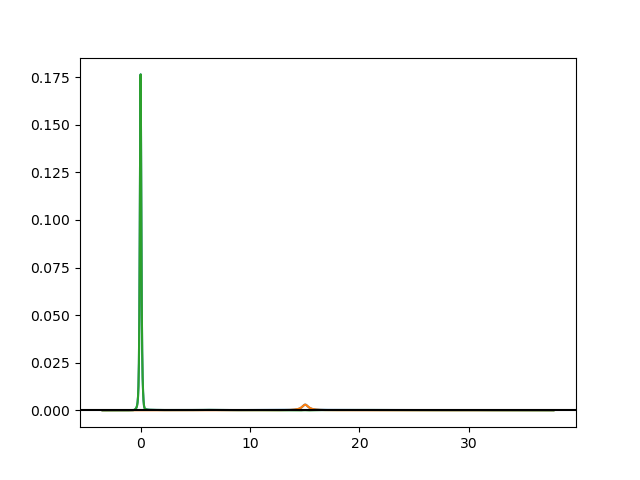

In [25]:
from scipy.optimize import leastsq

def Drude(E,Ep,Ew, gamma=1):
    eps = 1 - Ep**2/(E**2+Ew**2) +1j* Ew* Ep**2/E/(E**2+Ew**2)
    eps = 1 - (Ep**2 - Ew * E * 1j) / (E**2 + 2 * E * gamma * 1j)  # Mod drude ter
    elf = (-1/eps).imag
    return eps,elf

def errfDrude(p, y, x):
    eps,elf = Drude(x,p[0],p[1])
    err = y - p[2]*elf
    #print (p,sum(np.abs(err)))
    return np.abs(err)#/np.sqrt(y)


pin2 = np.array([9,1,.7, 1.11])
E = energy_scale = eels_dataset.energy_loss
startFit =np.argmin(abs(energy_scale-6))
endFit = np.argmin(abs(energy_scale-15))
    
p2, lsq = leastsq(errfDrude, pin2, args=(eels_dataset[startFit:endFit], energy_scale[startFit:endFit]), maxfev=2000)

eps, elf =Drude(energy_scale,p2[0],p2[1],p2[3])
drudePSD = p2[2]* elf
plt.figure()

plt.plot(energy_scale,eels_dataset)
plt.plot(energy_scale,drudePSD)
plt.plot(energy_scale,eels_dataset-drudePSD)
plt.axhline(0, color='black')

#plt.gca().set_xlim(0,40)
#plt.gca().set_ylim(-0.01,0.2)
print(f"Drude Theory with Plamson Energy: {p2[0]:2f} eV and plasmon Width {p2[1]:.2f} eV") 
print(f"Max of Plasmon at {energy_scale[drudePSD.argmax(0)]:.2f} eV")
print(f"Amplitude of  {p2[2]:.2f} was deteremined by fit ")
p2


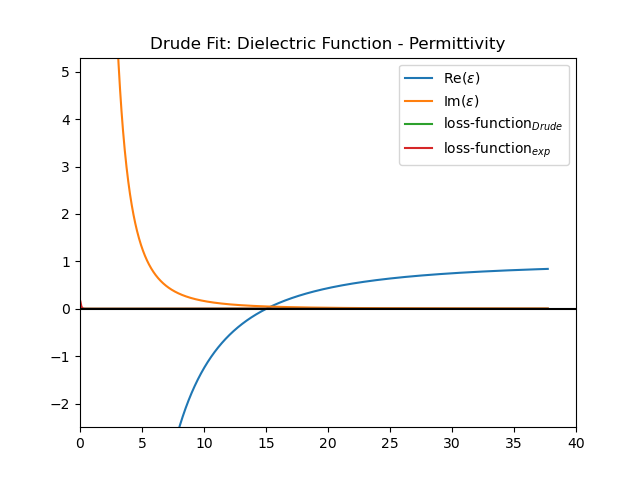

In [26]:
plt.figure()
plt.title ('Drude Fit: Dielectric Function - Permittivity')
plt.plot(energy_scale,eps.real,label = 'Re($\epsilon)$')
plt.plot(energy_scale,eps.imag,label = 'Im($\epsilon)$')
plt.plot(energy_scale,drudePSD,label = 'loss-function$_{Drude}$')
plt.plot(energy_scale,eels_dataset,label = 'loss-function$_{exp}$')
plt.axhline(0, color='black')

plt.gca().set_xlim(0,40)
plt.gca().set_ylim(-2.5,5.3)

plt.legend();

173


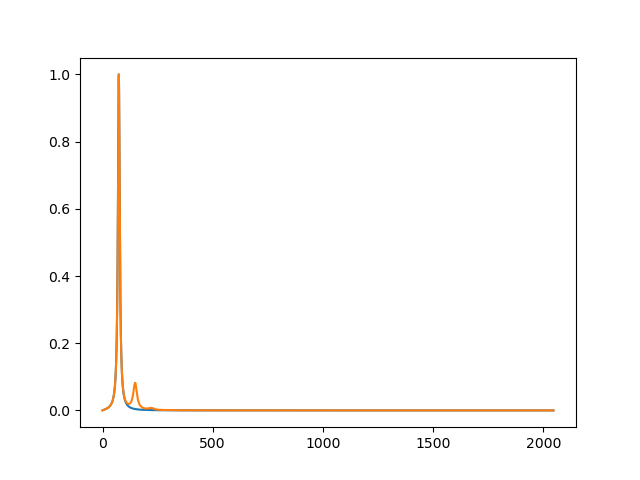

In [27]:
tmfp = .3
zl2 = zero_loss
        
LLene = np.arange(1,2048)/5

zero_loss, _ = eels_tools.resolution_function(eels_dataset.energy_loss, eels_dataset, .4)

ZP = np.array(zl2).argmax(0) # zl peak position 
print(ZP)

_, SSD = Drude(LLene,15, 2 )
PSD = np.zeros(len(LLene))
FAC = 1.

ssd  = np.fft.fft(SSD)
ssd2 = ssd.copy()
SSD2 = SSD.copy()
for order in range(20):
    # This order convoluted spectum 
    PPSD = np.zeros(len(LLene))
    # convoluted SSD is SSD2
    SSD2 = np.fft.ifft(ssd).real

    # scale right (could be done better? GERD)
    mult = sum(SSD)/sum(SSD2)

    SSD2 *= mult.real/np.exp(-tmfp)
    EP = np.array(SSD2).argmax(0)
    PPSD = SSD2/FAC*np.power(tmfp,(order))*np.exp(-tmfp)*1e12
    # Add this order t0 final spectrum
    PSD += PPSD
    # Get next order factor
    FAC=FAC*(order+2.)

    # convolute next order
    ssd = ssd * ssd2




            
plt.figure()
plt.plot(SSD/SSD.max())
plt.plot(PSD/PSD.max())

0.1765600943877315 1.7787569110952763


(-0.1, 0.2)

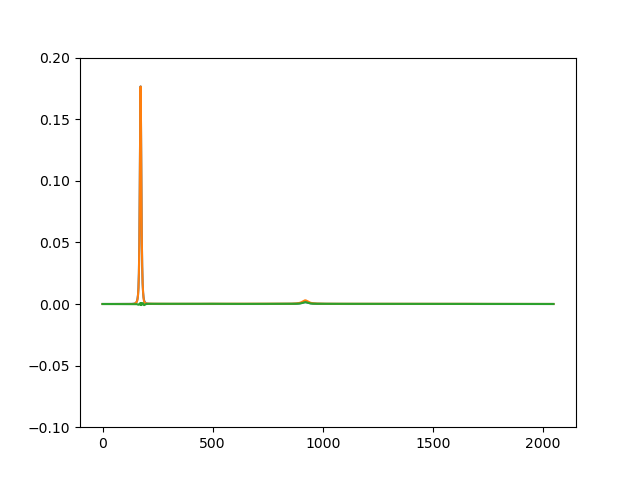

In [31]:
from scipy.interpolate import splev,splrep,splint
def MakeDrudeVL(dataset, tmfp, zero_loss, Ep, Ew, Eh):
        energy_scale = np.arange(1,2049)/5
        
        ZP = np.array(zero_loss).argmax(0) # zl peak position 
        _, PSD = Drude(energy_scale,Ep, Ew )
        PSD /= PSD.sum()
        
        FAC = 1.

        ### sum contribution from each order of scattering:
        ssd  = np.fft.fft(PSD)
        
        SSD_sum = PSD.sum()
        ssd2 = ssd.copy()
        PSD /= FAC*np.power(tmfp,(0))*np.exp(-tmfp)
        for order in range(1,15):
            FAC=FAC*(order+2.)
            ssd *= ssd2   
            # convoluted SSD is SSD2
            SSD2 = np.fft.ifft(ssd).real

            # scale right (could be done better? GERD)
            mult = SSD_sum/sum(SSD2)

            SSD2 *= mult.real/np.exp(-tmfp)
            EP = np.array(SSD2).argmax(0)
            PPSD = SSD2/FAC*np.power(tmfp,(order))*np.exp(-tmfp)
            # Add this order t0 final spectrum
            PSD += PPSD
            
            # convolute next order
        dispersion = dataset.energy_loss[1] - dataset.energy_loss[0]
        
        factorZL =  Eh/dispersion*2 #, #zero_loss.sum()*(np.exp(tmfp)-1)/PSD.sum()*Eh/dispersion/4
        #print(factorZL, Eh)
        
        BGDcoef = splrep(energy_scale,PSD,s=0)
        dispersion = dataset.energy_loss[1] - dataset.energy_loss[0]
        cts =splev( dataset.energy_loss, BGDcoef)*factorZL #*p[1]
        
        cts += zero_loss
        
        return cts
    
    

zero_loss, _ = eels_tools.resolution_function(eels_dataset.energy_loss, eels_dataset, .4)
Izl = zero_loss.sum()
Itotal = np.array(eels_dataset).sum()
tmfp = np.log(Itotal/Izl)



LL = MakeDrudeVL(eels_dataset, tmfp, zero_loss,p2[0],p2[1], p2[2])
print(LL.max(), LL.sum())
plt.figure()
plt.plot(LL)
plt.plot(eels_dataset)
plt.plot(eels_dataset-LL)

plt.ylim(-.1,.2)

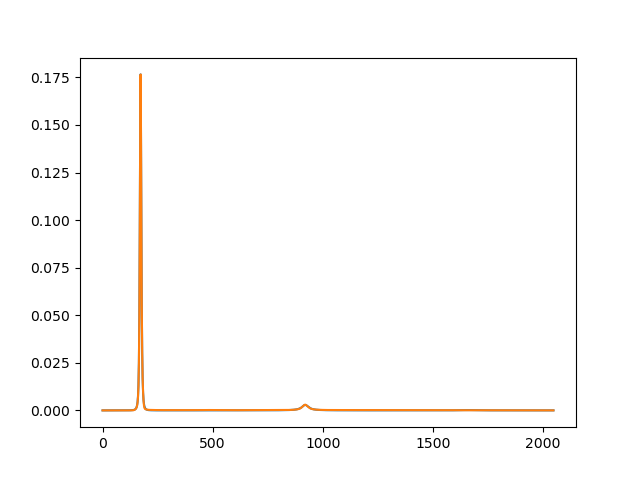

In [32]:

def errfDrude(p, y):
    LL = MakeDrudeVL(y, p[3], zero_loss, p[0],p[1],p[2])
    err = y - LL
    #print (p,sum(np.abs(err)))
    return np.abs(err)#/np.sqrt(y)


pin2 = np.array([15,1,.7, 0.3])
E = energy_scale = eels_dataset.energy_loss
startFit =np.argmin(abs(energy_scale-13))
endFit = np.argmin(abs(energy_scale-18))
    
p2, lsq = leastsq(errfDrude, pin2, args=(eels_dataset), maxfev=2000)

LL = MakeDrudeVL(eels_dataset, p2[3], zero_loss, p2[0],p2[1],p2[2])
plt.figure()
plt.plot(LL)
plt.plot(eels_dataset)

In [38]:
p2[3]

0.8326588466281821

In [34]:
np.power(0.3,(0))*np.exp(-.3)

0.7408182206817179

In [35]:
zero_loss.sum()

array(1.68808473)

In [ ]:
def newDrudeBgd(self,x,p):
    tags = self.tags

    startB = x[0]
    endB = x[-1]
    p = np.abs(p)


    LLene = np.linspace(0, 2047,2048)
    SSD =  self.Drude(LLene,p)
    ssd  = np.fft.fft(SSD)

    ssd2 = ssd.copy()
    SSD2 = SSD.copy()

    ### sum contribution from each order of scattering:
    PSD = np.zeros(len(LLene))
    for order in range(15):
        # This order convoluted spectum 
        PPSD = np.zeros(len(LLene))
        # convoluted SSD is SSD2
        SSD2 = np.fft.ifft(ssd).real

        # scale right (could be done better? GERD) 
        mult = sum(SSD)/sum(SSD2)
        SSD2 *= abs(mult)

        PPSD = SSD2/factorial(order+1)*np.power(tmfp,(order+1))*np.exp(-tmfp) #using equation 4.1 of egerton ed2
       # Add this order to final spectrum
        PSD += PPSD

        # next order convolution
        ssd = ssd * ssd2


    cts = np.zeros(len(x))

    if startB < 0:
        startB = 0
    BGDcoef = splrep(LLene[int(startB):int(endB)],PSD[int(startB):int(endB)],s=0)


    lin = np.zeros(len(x))

    cts =splev( x, BGDcoef)*p[1]

In [ ]:
def DrudeBgd(self, y, x, imfp ):


        p0 = np.zeros(4)
        if 'Drude P Pos' in self.tags:
            p0[0] = self.tags['Drude P Pos']
            p0[1] = self.tags['Drude P Width']
            p0[2] = self.tags['Drude P thick']
            p0[3] = self.tags['Drude P Assym']
  

        # Fit function is the spectrum - new LL bgd devided by poinson noise
        def newLL(p, y, x):
            err = (y - self.newDrudeBgd( x,p))
            #print(p, sum( err))
            return err/np.sqrt(y)

        # Least square fit
        pDLLBgd, lsq = leastsq(newLL, p0, args=(y, x), maxfev=2000)
        #print(sum(newLL(pZL, y, x)))
        # cts is the result of the fit
        cts=self.newDrudeBgd(tags['ene'],abs(pZL))
        #print("new LLL background ", pZL)
        self.tags['DrudeLLBgd'] = pDLLBgd
        
        
        return cts

In [47]:
def PMFP(ssdLL, energy_scale):
        # Calculate plasmon mean free paths using a free-electron formula Eq.(3.58)
        # with m = m0 and assuming small width of the plasmon peak.
        # Equally good for calculating total-inelastic MFP using a value of
        # Em in Eq.(5.38) or a more approximate value using Eq.(5.2).
        # Probe convergence alpha incorporated using Scheinfein & Isaacson formula.
        # Above values assume dipole conditions (beta* < Bethe-ridge angle).
        # The program also estimates a total-inelastic MFP by using dipole formula
        # with effective collection angle bstar = Bethe-ridge angle.
        # To obtain this value, enter alarge value (~ 100 mrad) for alpha or beta.
        E0 = 200000            #Incident-electron energy E0 (keV): ');
        Ep = energy_scale[0]+ssdLL.argmax(0)*(energy_scale[1]-energy_scale[0]) #'Plasmon energy of mean energy loss (eV): ');
        print(Ep, ssdLL.argmax(0))
        alpha = 10 #'Convergence semiangle (mrad) [can be 0]: ');
        beta  = 30 #'Collection semiangle (mrad): ');
        
        F = (1.0+E0/1022.0)/(1.0+E0/511.0)**2;
        Fg = (1.0+E0/1022.0)/(1.0+E0/511.0);
        T = E0*F; #keV
        tgt = 2.0*Fg*E0;
        a0 = 0.0529;  #nm
        #print('2.gamma.T = ',tgt);

        # calculation of convergence correction
        #tgt=2.*E0.*(1.+E0./1022.)./(1.+E0./511.); % keV
        thetae=(Ep+1e-6)/tgt;          # in mrad, avoid NaN for e=0
        a2=alpha*alpha*1e-6 + 1e-10;  #radians^2, avoiding inf for alpha=0
        b2=beta*beta*1e-6;            #radians^2
        t2=thetae*thetae*1e-6;        #radians^2
        eta1=np.sqrt((a2+b2+t2)**2-4*a2*b2)-a2-b2-t2;
        eta2=2*b2*np.log(0.5/t2*(np.sqrt((a2+t2-b2)**2+4*b2*t2)+a2+t2-b2));
        eta3=2*a2*np.log(0.5/t2*(np.sqrt((b2+t2-a2)**2+4*a2*t2)+b2+t2-a2));
        eta=(eta1+eta2+eta3)/a2/np.log(4/t2);
        f1=(eta1+eta2+eta3)/2/a2/np.log(1+b2/t2);
        f2=f1;
        if(alpha/beta>1):
            f2=f1*a2/b2;

        bstar=thetae*np.sqrt(np.exp(f2*np.log(1+b2/t2))-1); #% mrad
        #print('effective semiangle beta* = %g mrad\n',bstar);
        bstar = 40
        
        thetabr = 1000 * (Ep/E0/1000.0)**0.5;
        print('Bethe Ridge Angle', thetabr)
        #print('Bethe-ridge angle(mrad) = ',self.tags['Bethe Ridge Angle'],'nm\n')

        pmfp = 0.0
        imfp = 0.0
        if (bstar < thetabr):
            pmfp = 4000*a0*T/Ep/np.log(1+bstar**2/thetae**2);
            imfp = 106*F*E0/Ep/np.log(2.0*bstar*E0/Ep);
            #print('Free-electron   MFP(nm) = %g nm\n',pmfp);
            #print('Using Eq.(5.2), MFP(nm) = %g nm\n',imfp);
            
        else:
            #print('Dipole range is exceeded\n');
            imfp = 4000*a0*T/Ep/np.log(1+thetabr**2/thetae**2);
            #print('total-inelastic MFP(nm) = %g nm\n',imfp);
        

        return pmfp, imfp

In [48]:
Ep = np.array(eels_dataset.energy_loss)[0]+np.array(ssdLL).argmax(0)*(np.array(eels_dataset.energy_loss)[1]-np.array(eels_dataset.energy_loss)[0])
Ep,  np.array(ssdLL).argmax(0)

(15.040794864773837, 920)

In [51]:
PMFP(np.array(ssdLL), np.array(eels_dataset.energy_loss))

15.040794864773837 920
Bethe Ridge Angle 0.27423343035426806


(0.0, 219.06514501302627)

0.17584541453708571


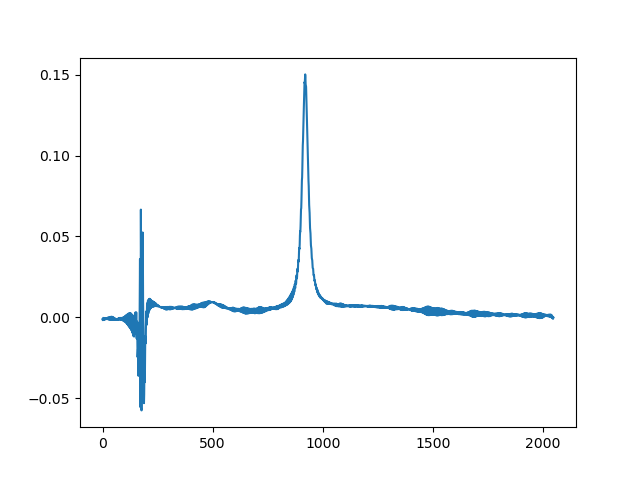

In [30]:
# Use resolution Function as ZL if existing
# print len(LLSpec)
LLSpec = eels_dataset
zero_loss, _ = eels_tools.resolution_function(eels_dataset.energy_loss, eels_dataset, .4)

j = np.fft.fft(eels_dataset)
z = np.fft.fft(zero_loss)
j1 = z*np.log(j/z)
ssdLL =np.fft.ifft(j1).real#,'fourier-log deconvolution')

#self.parent.text2.append('\n Single Scattering Deconvolution, Done')
if np.array(eels_dataset).sum() > 0.0:          
    tmfp = np.log(np.array(eels_dataset).sum()/zero_loss.sum())
else:
    tmfp = 0.0
Ep = np.array(eels_dataset.energy_loss)[0]+np.array(ssdLL).argmax(0)*(np.array(eels_dataset.energy_loss)[1]-np.array(eels_dataset.energy_loss)[0])

print(tmfp)
plt.figure()
plt.plot(ssdLL)

In [77]:
def drude(dataset,  ep, ew, tnm, eb, verbose=False):
       
    
    e0 = 200
    beta = 30
    e = dataset.energy_loss
    epc = e[1]-e[0]

    b = beta/1000.0 # %rad
    T = 1000.0*e0*(1.+e0/1022.12)/(1.0+e0/511.06)**2;# %eV # equ.5.2a or Appendix E p 427 
    tgt = 1000*e0*(1022.12 + e0)/(511.06 + e0);# %eV  Appendix E p 427 
    rk0 = 2590*(1.0+e0/511.06)*np.sqrt(2.0*T/511060);
    os = e[0]
    ewMod = eb
    eps = 1 - (ep**2-ewMod*e*1j)/(e**2+2*e*ew*1j) #Mod Drude term
    eps[np.nonzero(eps==0.0)]= 1e-19
    elf = np.imag(-1/eps)

    the = e/tgt; #% varies with energy loss! # Appendix E p 427 
    srfelf=np.imag(-4./(1.0+eps))-elf; #% for 2 surfaces
    angdep = np.arctan(b/the)/the - b/(b*b+the*the);
    srfint = angdep*srfelf/(3.1416*0.05292*rk0*T); #% probability per eV
    anglog = np.log(1.0+ b*b/the/the);
    I0 = eels_dataset.sum() *1     
    volint = abs(tnm/(np.pi*0.05292*T*2)*elf*anglog); #S equ 4.26% probability per eV
    volint = (volint+srfint) *I0  *epc #S probability per channel
    ssd = volint #+ srfint;
    if os <-1.0:
        xs = int(abs(-os/epc))

        ssd[0:xs]=0.0
        volint[0:xs]=0.0
        srfint[0:xs]=0.0
        
        Ps = np.trapz(e,srfint); #% 2 surfaces but includes negative begrenzungs contribn.
        Pv = abs(np.trapz(e,abs(volint/np.array(eels_dataset)))); #% integrated volume probability
        Pv = (volint/I0).sum() ## our data have he same epc and the trapz formula does not include 
        lam = tnm/Pv; #% does NOT depend on free-electron approximation (no damping). 
        lamfe = 4.0*0.05292*T/ep/np.log(1+(b* tgt / ep) **2); #% Eq.(3.44) approximation
    if verbose:
        print('Ps(2surfaces+begrenzung terms) =', Ps, 'Pv=t/lambda(beta)= ',Pv,'\n');
        print('Volume-plasmon MFP(nm) = ', lam,' Free-electron MFP(nm) = ',lamfe,'\n');
        print('--------------------------------\n');

            
    return ssd#/np.pi

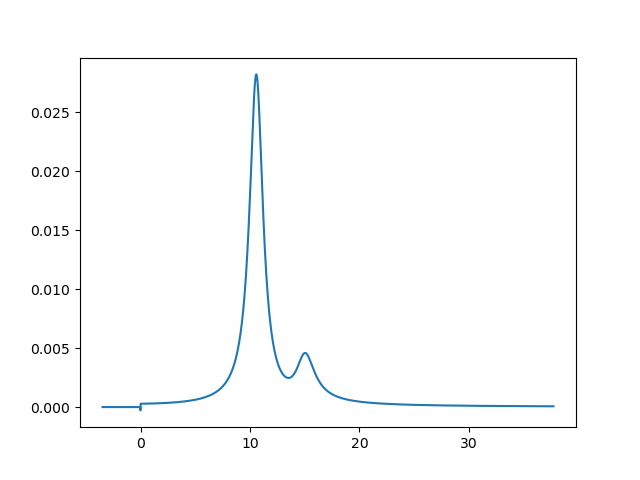

In [81]:
ssd = drude(eels_dataset,  15, .5, 3, 1)
plt.figure()
plt.plot(eels_dataset.energy_loss, ssd)

In [ ]:
def doSSD(LLSpec):
        
        # Use resolution Function as ZL if existing
        # print len(LLSpec)
        extract_zero_loss(LLSpec)
        
        j = np.fft.fft(LLSpec)
        z = np.fft.fft(self.tags['zero_loss'])
        z2 = z ## Could be a zl extracted from Spectrum
        j1 = z2*np.log(j/z)
        self.ssdLL =np.fft.ifft(j1).real#,'fourier-log deconvolution')
        self.tags['ssdLL']=self.ssdLL.copy()
        
        
        #self.parent.text2.append('\n Single Scattering Deconvolution, Done')
        if np.array(LLSpec).sum() > 0.0:          
            tmfp = np.log(np.array(LLSpec).sum()/self.tags['zero_loss'].sum())
        else:
            tmfp = 0.0

        # Use resolution function if available, use ZL otherwise
        zl2 = self.tags['zero_loss']
        
        
        #####################
        ####### for SSD convoluted Spectra
        #####################
        startE = (6.0-self.tags['offset'])/self.tags['dispersion']
        SSD = self.ssdLL.copy()
        SSD2 = SSD.copy()
        SSD2[0:startE]=0.0
        EP = np.array(SSD2).argmax(0) # plasmon peak position
        ZP = np.array(zl2).argmax(0) # zl peak position 
        #print ('\n EP: ',EP,startE, self.tags['offset']+EP*self.tags['dispersion'])


        guess = [self.tags['offset']+EP*self.tags['dispersion'], 10000.0, 6.0, 0.98]
        pin = np.array(guess)

        def errfct(p, y, x):
            err = (y - Lorentzian(x,p))
            return err

        def Lorentzian(x,p):
            y = ((0.5 *  p[1]* p[2]/3.14)/((x- p[0])**2+(( p[2]/2)**2)))
            return y

        p, lsq = leastsq(errfct, pin, args=(SSD, self.tags['ene']), maxfev=2000)
        self.tags['PLpos'] = p[0]
        self.tags['PLwidth'] = p[2]
        self.tags['PLarea'] = p[1]
        #self.parent.text2.insertPlainText('\n Position 1  Amplitude 1,  Width 1,  \n')
        #self.parent.text2.insertPlainText(str(p[0:3]))
        PL1 =  Lorentzian(self.tags['ene'],p)

        pmfp, imfp = self.PMFP()
        startxE = self.tags['Drude Fit Start']
        endxE = self.tags['Drude Fit End']
        startx = (startxE-self.tags['offset'])/self.tags['dispersion']
        endx = (endxE-self.tags['offset'])/self.tags['dispersion']

        if p[0] < startxE:
            p[0] = startxE
        if p[0] > endxE:
            p[0] = endxE
        if p[2] > (endxE-startxE)/2.0:
            p[2] = (endxE-startxE)/2.0
        
        
        guess = [p[0],p[2],tmfp*imfp,0.1,1.0]
        guess = [22,10,50,0.1,1.0]
        pin2 = np.array(guess)

        
        def errfDrude(p, y, x):
            p = abs(p)
            if p[0] < startxE:
                p[0] = startxE
            if p[0] > endxE:
                p[0] = endxE
            if p[1] > endxE-startxE/3.0:
                p[1] = endxE-startxE/3.0
            if p[2] > 200:
                p[2] = 200
            if p[2]<0:
                p[2] =0
            if p[3] > 10:
                p[3] = 10
            if p[3]<0:
                p[3] =0
            if not self.tags['Drude Fit Asymm'] :
                p[3] = 0
            
            err = (y - self.drude(x,p[0],p[1],p[2],abs(p[3])))

            y[np.nonzero(y<=0)] = 1e-12
            return np.abs(err)/np.sqrt(y)
        
        

        
        p2, lsq = leastsq(errfDrude, pin2, args=(self.tags['spec'][startx:endx], self.tags['ene'][startx:endx]), maxfev=2000)
        p2[3] = abs(p2[3])
        self.drudePSD = self.drude(self.tags['ene'],p2[0],p2[1],p2[2],abs(p2[3]))
        self.tags['Drude SSD'] = self.drudePSD
        
        self.tags['Drude P Pos'] = p2[0]
        self.tags['Drude P Width'] = p2[1]
        self.tags['Drude P thick'] = p2[2]
        self.tags['Drude P Assym'] = abs(p2[3])
        Pv = self.drudePSD.sum()/self.tags['spec'].sum()
        self.tags['Drude P Probab'] = Pv
        self.tags['Drude P IMFP'] =  p2[2]/Pv #(Wave vs. intensity)
        #self.tags['Drude P/LL IMFP',p2[2]/tmfp,'nm')
        self.tags['LLthick'] = tmfp

        e = 1.60217646E-19; #% electron charge in Coulomb
        eps0 =  8.854187817*1e-12 # vacuum permittivity
        mel = 9.109e-31; #% REST electron mass in kg
        h = 4.135667516*1e-15; #% Planck's constant
        hbar = h/2.0/np.pi;

        self.tags['Drude e- density']= np.sqrt( (p2[0]/hbar)**2/e**2*eps0*mel)*1e-7 #gerd true? /nm^2

        self.tags['Drude VL'] = self.MakeDrudeVL()
        
        
        return tmfp

## Surface Plasmon

Spectra from thin specimen show the excitations of the surface plasmons on each side of the specimen. For any normal specimen these surface plasmons do interact, but this is not true for extremely thick specimen ($>> 10$nm).
The surface plasmon frequency $\omega_S$ for thin specimen  is related to the bulk plasmon frequency $\omega_P$ by Ritchie [Ritchie-PR1957]:  
$$
\omega_S=\omega_P\left[  \frac{1\pm \exp(-q_st) }{1+\varepsilon} \right]^{1/2}
$$


The symmetric mode, where like charges face one another, corresponds to the higher angular frequency $q_s$. Please note, that this relationship does only apply for large $q_s$

The differential probability for surface excitation at both surfaces of a sample with thickness $t$ can be expressed (normal incident, no retardation effects) by:
$$
\frac{d^2 P_s}{d\Omega d E}=\frac{2\hbar}{\pi^2 \gamma a_0 m_0^2 \mu^3}\frac{\theta}{(\theta^2+\theta^2_E)^2} \Im\left[  \frac{(\varepsilon_a - \varepsilon_b)^2 } {\varepsilon_a^2 \varepsilon_b}\right]
$$
with 
$$
R_c = \frac{\varepsilon_a \sin^2(tE/2\hbar\mu)}{\varepsilon_b + \varepsilon_z }\tanh (q_s t/2) 
+ \frac{\varepsilon_a \cos^2(tE/2\hbar\mu)}{\varepsilon_b + \varepsilon_a} \coth (q_s t/2) 
$$
and $\varepsilon_a$ and $\varepsilon_b$ are the permitivities of the two surfaces.


A secondary effect of the surface excitation is the reduced intensity of the bulk plasmon peak. The effect is usually smaller than 1\%, but can be larger for spectra with small collection angle, because the preferred scattering of surfuce losses into small angles.
The correction for surface plasmon will be discussed in the Kramers--Kronig Analysis.



## Summary

The beauty of ``Low--Loss spectroscopy`` is its derivation of the dielectric function to high energies without prior knowledge of the composition. The signal is strong and the acquisition time is mostly restricted by the dynamic range of the spectrum.


**Think of low-loss spectroscopy as Electrodynamics**

The advantages of EELS is the derivation of these values spatially resolved.
And from a linescan across an Si/SiO$_2$ interface the dielectric function per pixel can be obtained. From that we can calculate the dielectric polarizability $\alpha_e (E)$, which may be  a measure of the dielectric strength.


We obtain more or less easily:
- relative thickness
- absolute thickness 
- inelastic mean free path
- plasmon frequency
- plasmon width
- band gap
- dielectric function
- reflectivity 
- absorption
- effective number of electrons per atoms 
 


The analysis of the optical data requires the exact knowledge of the zero-loss peak. Because of the weighting in the Fourier Analysis, the low energy part contributes heavily to the dielectric function. Therefore, energy resolution is critical for an exact determination of all the optical values from EELS. The new monochromated TEMs are now able to achieve an energy resolution of 10 meV (one is at the oak Ridge National Laboratory), which allows for a sharper zero-loss peak. Such a sharp zero-loss peak will enable us to extract this low energy data more accurately. The dielectric function and the parameters derived from it, can be more precisely determined from such EELS spectra.


## Navigation
- <font size = "3">  **Up Chapter 4: [Imaging](CH4_00-Spectroscopy.ipynb)** </font>
- <font size = "3">  **Back: [Zero-Loss](CH4_02-Fit_Zero_Loss.ipynb)** </font>
- <font size = "3">  **Next: [Introduction to Core-Loss](./CH4_07-Introduction_Core_Loss.ipynb)** </font>
- <font size = "3">  **List of Content: [Front](../_MSE672_Intro_TEM.ipynb)** </font>